# Predicting Revenue in Dynamic Pricing : A Machine Learning Approach for a Mail-Order Pharmacy

## Introduction

Dynamic pricing is a revenue management pricing method in which companies create variable prices for goods or services in line with the demands of the market. In the field of online trading, dynamic pricing tactics have grown in significance, especially for big online stores that sell a wide variety of goods. These companies rely on automated product pricing modifications to maximise their sales and profit margins.

In this project, we will be investigating the dynamic pricing approach adapted by a mail-order pharmacy for its online store and build a revenue forecasting model out of it. The pharmacy has implemented a daily automatic price adjustment strategy that requires them to keep track of prices, revenue totals, and different product features. Additionally, user behavior, including actions such as product clicks, basket assignments, and purchases, is also captured. The primary goal is to create a model based on three months of historical data to estimate revenue figures for the following month, with the goal of getting the most accurate forecast results possible.

## Data Overview

The datasets for developing the model and estimating revenue are obtained from the Kaggle site, which is linked below:

https://www.kaggle.com/datasets/oscarm524/revenue-forecast

The complete dataset provided for the three-month learning period includes the "items.csv" and "train.csv" files. To evaluate the model's effectiveness, the "class.csv" and "items.csv" files contain product attributes and prices for a future one-month categorization period. To maintain simplicity and reduce the number of categorical features, merging with the "items.csv" file is avoided in this particular implementation.

In [1]:
# loading the required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras import metrics

## Preliminary Analysis

We will load and take a look at the "train.csv" dataset on which we will build our model. 

In [2]:
# Loading the data
data = pd.read_csv("train.csv", sep = '|')
# Top 5 records of the dataset
data.head(5)

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14


In [3]:
# Dimensions of the dataset
data.shape

(2756003, 11)

#### Data Cleaning

We will clean the raw data before analysis. The first step is to check for missing values and remove them if they are present.

In [4]:
data.isnull().sum()

lineID                  0
day                     0
pid                     0
adFlag                  0
availability            0
competitorPrice    100687
click                   0
basket                  0
order                   0
price                   0
revenue                 0
dtype: int64

In [5]:
data = data.dropna()

The dimensions of the dataframe after removing the missing values are:

In [6]:
data.shape

(2655316, 11)

Next, we'll check for duplicate records.

In [7]:
data.duplicated().sum()

0

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2655316 entries, 0 to 2756002
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   lineID           int64  
 1   day              int64  
 2   pid              int64  
 3   adFlag           int64  
 4   availability     int64  
 5   competitorPrice  float64
 6   click            int64  
 7   basket           int64  
 8   order            int64  
 9   price            float64
 10  revenue          float64
dtypes: float64(3), int64(8)
memory usage: 243.1 MB


We can convert the variables day, adflag, availability, click, basket, and order into categorical variables. The variable 'day' consists of values from 1 to 92 for the days of the three months under which the data is collected. The 'adFlag' variable indicates whether the product is part of an advertising campaign. The variable 'availability' contains values 1, 2, 3, and 4. Variables 'click', 'basket' and 'order' have values of 0 or 1 based on whether the particular record included the item being clicked, added to the basket,or purchased. All of this information is obtained from the features.pdf file available with the dataset.

In [9]:
data['day'] = data['day'].astype('category')
data['adFlag'] = data['adFlag'].astype('category')
data['availability'] = data['availability'].astype('category')
data['click'] = data['click'].astype('category')
data['basket'] = data['basket'].astype('category')
data['order'] = data['order'].astype('category')

It is decided to omit the process of outlier check and removal for the numerical data in this dataframe, which includes price, competitor price, and revenue values. Since these variables are inherently prone to variability and extreme values, such as high-priced products or exceptional revenue outcomes, it is essential to preserve the integrity of the data and maintain a realistic representation of the market dynamics.

#### Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an essential step in the data analysis process that involves reviewing and summarising the primary properties of a dataset to acquire insights, detect patterns, and uncover correlations between variables. The first step is to summarise and correlate the numerical variables revenue, competitorPrice, and price. While correlation plots offer a thorough perspective of the links and dependencies between variables, helping analysts spot patterns and associations, summary statistics give a high-level overview of the data and help comprehend its central tendency, dispersion, and form.

In [10]:
# summary of the numerical variables
summary = ['competitorPrice', 'price', 'revenue']
round(data[summary].describe(),2)

,competitorPrice,price,revenue
count,2655316.00,2655316.00,2655316.00
mean,12.77,13.64,3.78
std,12.75,13.22,10.24
min,0.00,0.02,0.00
25%,5.48,5.95,0.00
50%,8.99,9.85,0.00
75%,15.06,16.45,2.15
max,264.59,323.98,887.70


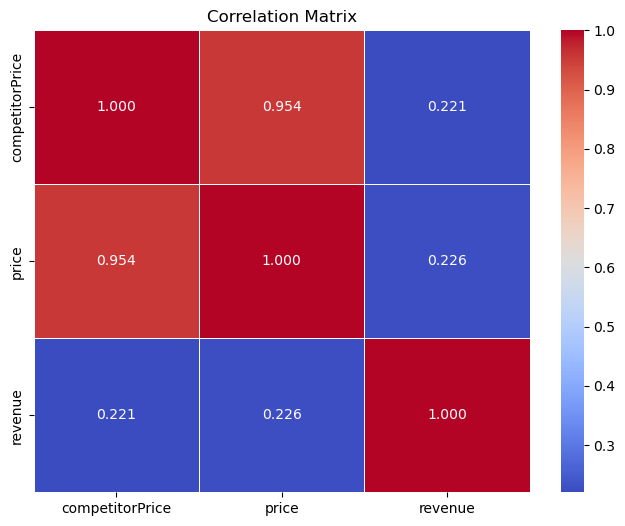

In [11]:
# Correlation matrix
correlation_matrix = data[summary].corr()
# Correlation Plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

A cross-table was generated to analyse the relationships between the variables click, basket, and order, providing insights into the distribution and associations of these variables.

In [12]:
cross_table = pd.crosstab(index = data['order'], columns = [data['click'], data['basket']])
cross_table

click        0                1
basket       0       1        0
order                          
0            0  455935  1510570
1       688811       0        0

Below are the proportions of clicks, baskets, and orders over the three-month period.

In [13]:
# Total count of records
total_count = len(data)
# Count of each variables
count_click = data['click'].value_counts()
count_basket = data['basket'].value_counts()
count_order = data['order'].value_counts()
# Create a DataFrame for the proportion table
proportion_table = pd.DataFrame({
    'click_proportion': count_click / total_count,
    'basket_proportion': count_basket / total_count,
    'order_proportion': count_order / total_count
})
percentage_table = (proportion_table.round(2))*100
# Printing the True value proportions of the variables
print(percentage_table.iloc[1])

click_proportion     57.0
basket_proportion    17.0
order_proportion     26.0
Name: 1, dtype: float64


The frequency of records was analysed over a three-month period, providing insights into the number of occurrences during that timeframe on each day.

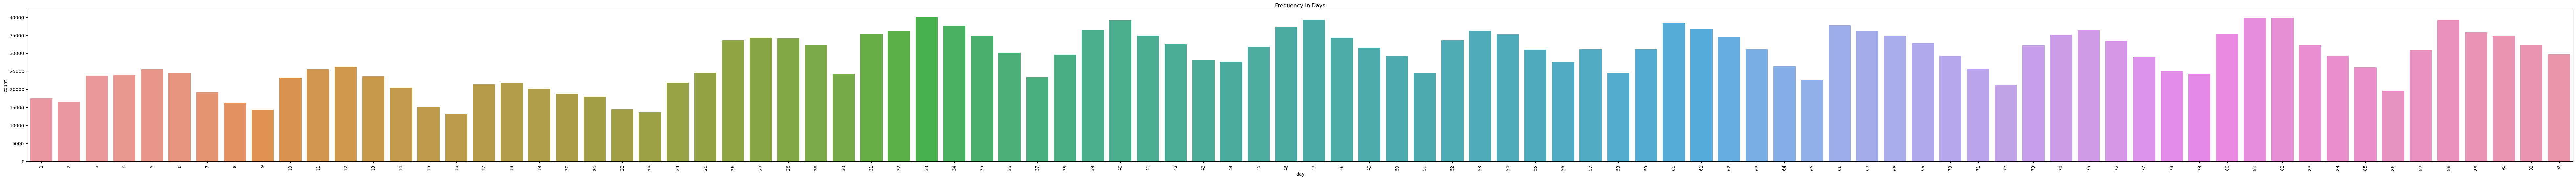

In [14]:
plt.figure(figsize=(100,6))
sns.countplot(data=data, x=data['day'])
plt.title('Frequency in Days')
plt.xticks(rotation = 90)
plt.show()

The revenue was summed for each day over a period of 92 days, and a plot was generated to visualise the revenue from day 1 to day 92.

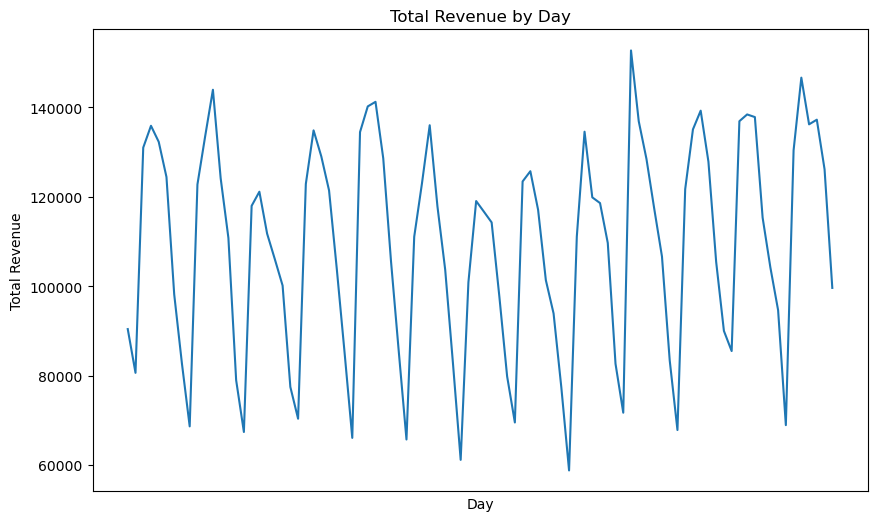

In [15]:
daily_revenue = data.groupby('day')['revenue'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(daily_revenue['day'], daily_revenue['revenue'])
plt.xlabel('Day')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Day')
plt.xticks(rotation=45)
plt.xticks([])
plt.show()

Finally, a comparison was conducted between the price of the products and the competitor's price over the time period.

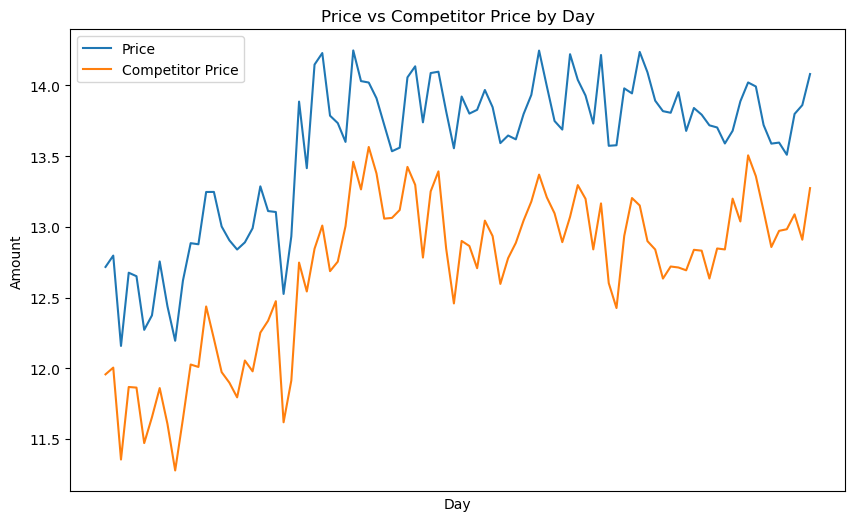

In [16]:
daily_prices = data.groupby('day')[['price', 'competitorPrice']].mean().reset_index()
daily_prices = daily_prices.sort_values('day')
plt.figure(figsize=(10, 6))
plt.plot(daily_prices['day'], daily_prices['price'], label='Price')
plt.plot(daily_prices['day'], daily_prices['competitorPrice'], label='Competitor Price')
plt.xlabel('Day')
plt.ylabel('Amount')
plt.title('Price vs Competitor Price by Day')
plt.legend()
plt.xticks(rotation=45)
plt.xticks([])
plt.show()

Before proceeding to the machine learning models, appropriate data preprocessing steps were further applied to ensure the data's quality and suitability for modelling.  

#### Data pre-processing

As the data in the 'class.csv' file  that need to be forecasted based on this model only contains 7 features, we'll build a model with only those 7 features. The columns click, basket, and order will be eliminated from our dataframe in order to accomplish that. Then, 'revenue' is set as the response variable and the rest as predictors.

In [17]:
columns_to_drop = ['click', 'basket', 'order', 'revenue']
x = data.drop(columns = columns_to_drop, axis = 1)
y = data['revenue']

Since all the values in the dataset are already numeric, there is no need for encoding. Scaling is done to ensure that all variables contribute equally during the model training process and to prevent certain variables from dominating or being ignored due to their larger magnitude. The standard scaling used here transforms the data to have a mean of 0 and a standard deviation of 1.

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(x)

As the final step in the data preprocessing stage, the dataset is split into training and testing sets. By splitting the data into training and testing sets, we can estimate how well the trained models will perform when deployed in real-world scenarios. This helps prevent overfitting and allows for an unbiased assessment.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Methods

#### Linear Regression

A common statistical modelling method for analysing and forecasting continuous data is linear regression. In this model, the dependent variable and the independent variables are assumed to have a linear relationship.

In [20]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

This linear regression model fitted with the training data is used to predict the response variable in the testing dataset. To assess the performance and accuracy evaluation metrics, mean squared error, mean absolute error, and R-squared value are used.

In [21]:
# Predicting the response variable
y_linear_pred = linear_model.predict(X_test)
# Evaluation metrics
mse_linear = mean_squared_error(y_test, y_linear_pred)
print('MSE for Linear Regression : ', mse_linear)
mae_linear = mean_absolute_error(y_test, y_linear_pred)
print('MAE for Linear Regression : ', mae_linear)
r2_linear = r2_score(y_test, y_linear_pred)
print('R-squared value for Linear Regression : ', r2_linear)

MSE for Linear Regression :  95.72363398816583
MAE for Linear Regression :  5.63603344161877
R-squared value for Linear Regression :  0.06361498830063284


#### Random Forest Regression

Random Forest Regression is a powerful machine learning algorithm that extends the concept of decision trees to perform regression tasks. It is suitable for complex regression issues because it can capture non-linear correlations between independent factors and the dependent variable. Similar evaluation metrics used for linear regression, such as mean squared error (MSE), mean absolute error (MAE), and R-squared value, can be used to evaluate the performance of Random Forest Regression.

In [22]:
random_model = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42)
random_model.fit(X_train, y_train)
# Prediction
y_random_pred = random_model.predict(X_test)
# Evaluation
mse_random = mean_squared_error(y_test, y_random_pred)
print('MSE for Random Forest Regression : ', mse_random)
mae_random = mean_absolute_error(y_test, y_random_pred)
print('MAE for Random Forest Regression : ', mae_random)
r2_random = r2_score(y_test, y_random_pred)
print('R-squared value for Random Forest Regression : ', r2_random)

MSE for Random Forest Regression :  91.12615154216365
MAE for Random Forest Regression :  5.402158106592303
R-squared value for Random Forest Regression :  0.10858835041222581


#### Artificial Neural Networks

Artificial Neural Networks (ANNs) are a class of machine learning models inspired by the structure and functioning of biological neural networks in the human brain. ANNs are powerful computational models that excel at solving complex problems by learning from data.

In [23]:
# Clearing data from previous ANN models
clear_session()
# Finding number of features for input dimension
input_dim = X.shape[1]
# Creating the model
model_ANN = Sequential()
model_ANN.add(layers.Dense(7, activation = 'relu', input_dim = input_dim))
model_ANN.add(layers.Dense(1, activation = 'linear'))
model_ANN.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()])
model_ANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fitting the model with training data
model_ANN.fit(X_train, y_train, epochs = 10, batch_size = 50, validation_split = 0.2)

Epoch 1/10
33989/33989 [==============================] - 58s 2ms/step - loss: 99.2200 - mean_squared_error: 99.2200 - mean_absolute_error: 5.6081 - val_loss: 96.3673 - val_mean_squared_error: 96.3673 - val_mean_absolute_error: 5.6248
Epoch 2/10
33989/33989 [==============================] - 44s 1ms/step - loss: 98.7286 - mean_squared_error: 98.7286 - mean_absolute_error: 5.6420 - val_loss: 96.1797 - val_mean_squared_error: 96.1797 - val_mean_absolute_error: 5.6849
Epoch 3/10
33989/33989 [==============================] - 46s 1ms/step - loss: 98.6299 - mean_squared_error: 98.6299 - mean_absolute_error: 5.6411 - val_loss: 96.1058 - val_mean_squared_error: 96.1058 - val_mean_absolute_error: 5.6025
Epoch 4/10
33989/33989 [==============================] - 46s 1ms/step - loss: 98.5528 - mean_squared_error: 98.5528 - mean_absolute_error: 5.6371 - val_loss: 96.1184 - val_mean_squared_error: 96.1184 - val_mean_absolute_error: 5.6635
Epoch 5/10
33989/33989 [==============================] - 45

In [25]:
# Model Evaluation
test_loss, test_mse, test_mae = model_ANN.evaluate(X_test, y_test, verbose = False)
print("Test Loss:", test_loss)
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

Test Loss: 94.64598846435547
Test MSE: 94.64598846435547
Test MAE: 5.655950546264648


In [26]:
# Prediction using the ANN model
y_ann_pred = model_ANN.predict(X_test, verbose = False)
mse_ANN = mean_squared_error(y_test, y_ann_pred)
print('MSE for Artificial Neural Network Model : ', mse_ANN)
mae_ANN = mean_absolute_error(y_test, y_ann_pred)
print('MSE for Artificial Neural Network Model : ', mae_ANN)
r2_ANN = r2_score(y_test, y_ann_pred)
print('R-sqaured value for Artificial Neural Network Model : ', r2_ANN)

MSE for Artificial Neural Network Model :  94.64589584219077
MSE for Artificial Neural Network Model :  5.655961492685771
R-sqaured value for Artificial Neural Network Model :  0.07415760776023739


## Results

When comparing multiple models, it is critical to select the best one based on a thorough examination and comparison of various indicators. Common measures for evaluating the performance of regression models include Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2). By examining these metrics, we can obtain insight into different aspects of the models and make the best choice. The evaluation metrics of all three models are printed below:

In [27]:
print("\033[1mEvaluation Metrics of Linear Regression\033[0m")
print('MSE for Linear Regression : ', mse_linear)
print('MAE for Linear Regression : ', mae_linear)
print('R-squared value for Linear Regression : ', r2_linear)
print("\033[1mEvaluation Metrics of Random Forest Regression\033[0m")
print('MSE for Random Forest Regression : ', mse_random)
print('MAE for Random Forest Regression : ', mae_random)
print('R-squared value for Random Forest Regression : ', r2_random)
print("\033[1mEvaluation Metrics of Artificial Neural Network Model\033[0m")
print('MSE for Artificial Neural Network Model : ', mse_ANN)
print('MAE for Artificial Neural Network Model : ', mae_ANN)
print('R-sqaured value for Artificial Neural Network Model : ', r2_ANN)

Evaluation Metrics of Linear Regression
MSE for Linear Regression :  95.72363398816583
MAE for Linear Regression :  5.63603344161877
R-squared value for Linear Regression :  0.06361498830063284
Evaluation Metrics of Random Forest Regression
MSE for Random Forest Regression :  91.12615154216365
MAE for Random Forest Regression :  5.402158106592303
R-squared value for Random Forest Regression :  0.10858835041222581
Evaluation Metrics of Artificial Neural Network Model
MSE for Artificial Neural Network Model :  94.64589584219077
MAE for Artificial Neural Network Model :  5.655961492685771
R-sqaured value for Artificial Neural Network Model :  0.07415760776023739


The mean squared error (MSE) and mean absolute error (MAE) are used to compare the anticipated and actual values, with a lower MSE indicating better error reduction. The R-squared metric assesses model fit, with a higher R2 indicating better prediction capability. For this dataset, we can see that the Random Forest Regression has the lowest MSE and MAE, as well as the greatest R-squared value, making it the best model of the three. So, we can select this model for forecasting revenue on the 'class.csv' dataset. We have another file 'realclass.csv' that contains the actual revenue for the one month data which we can use to test the effectiveness of the model.

In [28]:
# Loading the data for forecast
forecast = pd.read_csv("class.csv", sep = "|")
real = pd.read_csv('realclass.csv', sep = '|')

In [29]:
# Merging the data
final = pd.merge(forecast, real, on = 'lineID')

In [30]:
# Dimensions of the data
final.shape

(1210767, 8)

In [31]:
# Checking for missing values
final.isnull().sum()

lineID                 0
day                    0
pid                    0
adFlag                 0
availability           0
competitorPrice    38005
price                  0
revenue                0
dtype: int64

In [32]:
# Removing missing values
final = final.dropna()

In [33]:
# Checking for duplicates
final.duplicated().sum()

0

In [34]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172762 entries, 0 to 1210766
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   lineID           1172762 non-null  int64  
 1   day              1172762 non-null  int64  
 2   pid              1172762 non-null  int64  
 3   adFlag           1172762 non-null  int64  
 4   availability     1172762 non-null  int64  
 5   competitorPrice  1172762 non-null  float64
 6   price            1172762 non-null  float64
 7   revenue          1172762 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 80.5 MB


In [35]:
# Changing the datatypes of 'day', 'adFlag' and 'availability'
final['day'] = final['day'].astype('category')
final['adFlag'] = final['adFlag'].astype('category')
final['availability'] = final['availability'].astype('category')

In [36]:
# Splitting into subsets for prediction and evaluation
x = final.drop(columns = 'revenue', axis = 1)
y = final['revenue']
# Scaling the data
scaler = StandardScaler()
X = scaler.fit_transform(x)

In [37]:
# Predicting the data using the model
rev_pred = random_model.predict(X)

In [38]:
# Evaluation
mean_squared_error(y, rev_pred)
mean_absolute_error(y, rev_pred)

mse_forecast = mean_squared_error(y, rev_pred)
print('MSE for Forecasted Revenue : ', mse_forecast)
mae_forecast = mean_absolute_error(y, rev_pred)
print('MAE for Forecasted Revenue : ', mae_forecast)

MSE for Forecasted Revenue :  83.35295617700176
MAE for Forecasted Revenue :  5.349759363217051


We can see that the mean squared error and mean absolute error values are even lower for the forecasting model, which confirms the effectiveness of the model for revenue prediction.

## Conclusion

The purpose of this study was to create a revenue forecasting model for dynamic pricing based on three months' worth of data from a mail-order pharmacy's online store. We learned more about the distribution and correlations of variables in the cleaned dataset through exploratory data analysis (EDA). Before proceeding to machine learning models, appropriate data preprocessing steps were applied, including eliminating unnecessary variables and scaling the data to ensure equal contribution during model training.

Linear regression, random forest regression, and artificial neural networks (ANNs) methods were employed on the dataset and compared as potential revenue forecasting models. The performance of the models was evaluated using measures like mean squared error (MSE), mean absolute error (MAE), and R-squared value. Based on the evaluation metrics, the random forest regression model exhibited the lowest MSE and MAE, along with the highest R-squared value, indicating its superior predictive capability.

In conclusion, this project demonstrated the effectiveness of random forest regression learning in forecasting revenue better than the other two models considered. This random forest regression model can be utilised to make accurate revenue predictions, aiding in decision-making and maximising profitability.